# Lab 4: Regularization and Cross-Validation


\begin{exercise}
Consider the kc_house_data.csv dataset and modify Lab 4 notebook to study the effect of regularization in the following pairs a) "Price vs Square Feet" and b) "Price vs Location of the area".

\end{exercise}

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
#import seaborn.apionly as sns
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
df=pd.read_csv("kc_house_data.csv")
df1 = df[['price','sqft_living']]
df1.head()

,price,sqft_living
0,221900.0,1180
1,538000.0,2570
2,180000.0,770
3,604000.0,1960
4,510000.0,1680


In [3]:
x = df1.sqft_living.values
y = df1.price.values
df1.shape

(21613, 2)

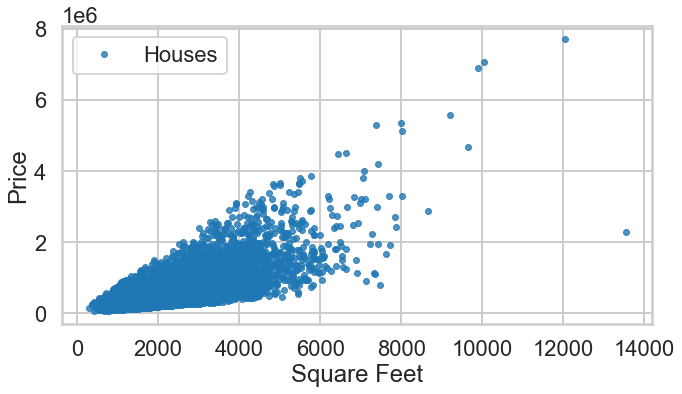

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(x, y, '.', alpha=0.8, label=r'Houses')

ax.legend(loc='upper left')

ax.set_xlabel('Square Feet')
ax.set_ylabel('Price')

fig.tight_layout()

In [5]:
indexes=np.sort(np.random.choice(x.shape[0], size=100, replace=False)) # Using sort to make plotting easier later
indexes

array([   98,   384,   618,   680,   755,   915,  1185,  1323,  1534,
        1552,  1665,  2293,  2506,  2560,  2954,  3184,  3445,  3534,
        3792,  3967,  4317,  4406,  4653,  4858,  5022,  5134,  5174,
        5445,  5636,  5827,  6093,  6203,  6845,  7320,  7321,  7463,
        7670,  7679,  7931,  8017,  8179,  8216,  8583,  8584,  8587,
        8685,  8718,  8738,  8917,  8942,  9071,  9629,  9705, 10736,
       10968, 11449, 11667, 12030, 12110, 12282, 12289, 12324, 12625,
       12827, 12872, 12949, 12978, 13461, 13941, 14544, 14866, 15071,
       15199, 15782, 16017, 16376, 16459, 16654, 17680, 17686, 17793,
       17854, 17944, 17965, 18152, 18215, 18384, 18533, 18779, 18957,
       18975, 19095, 19160, 19228, 19335, 20106, 20764, 21246, 21391,
       21522])

In [6]:
sample_df = pd.DataFrame(dict(x=x[indexes],y=y[indexes])) # New dataframe
sample_df.head()

,x,y
0,1810,314000.0
1,4800,1350000.0
2,1250,175000.0
3,1440,222000.0
4,1600,316500.0


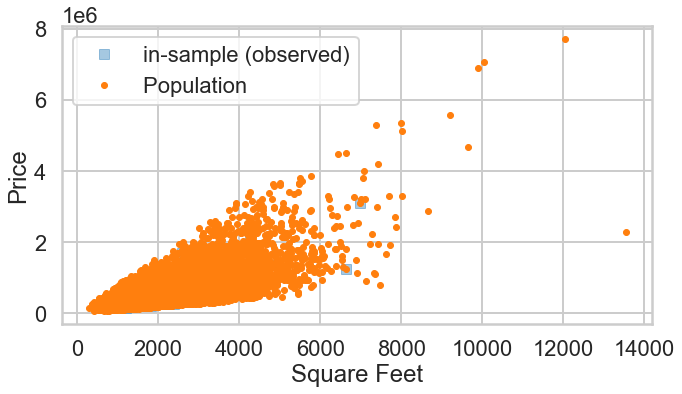

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(sample_df['x'], sample_df['y'], 's', alpha=0.4, ms=10, label="in-sample (observed)")
ax.plot(x,y, '.', label=r'Population ')

ax.legend(loc='upper left')

ax.set_xlabel('Square Feet')
ax.set_ylabel('Price')

fig.tight_layout()

In [8]:
from sklearn.model_selection import train_test_split

datasize=sample_df.shape[0]

#split dataset using the index, as we have x, f, and y that we want to split.
train, test = train_test_split(np.arange(100), train_size=0.8)

xtrain = sample_df.x[train].values
ytrain = sample_df.y[train].values

xtest= sample_df.x[test].values
ytest = sample_df.y[test].values

In [9]:
from sklearn.linear_model import LinearRegression

# fit the model to training data
simp_reg = LinearRegression().fit(xtrain.reshape(-1,1), ytrain)

# save the beta coefficients
beta0_sreg = simp_reg.intercept_
beta1_sreg = simp_reg.coef_[0]

print("(beta0, beta1) = ({0:8.6f}, {1:8.6f})".format(beta0_sreg, beta1_sreg))

(beta0, beta1) = (39659.643416, 227.957011)


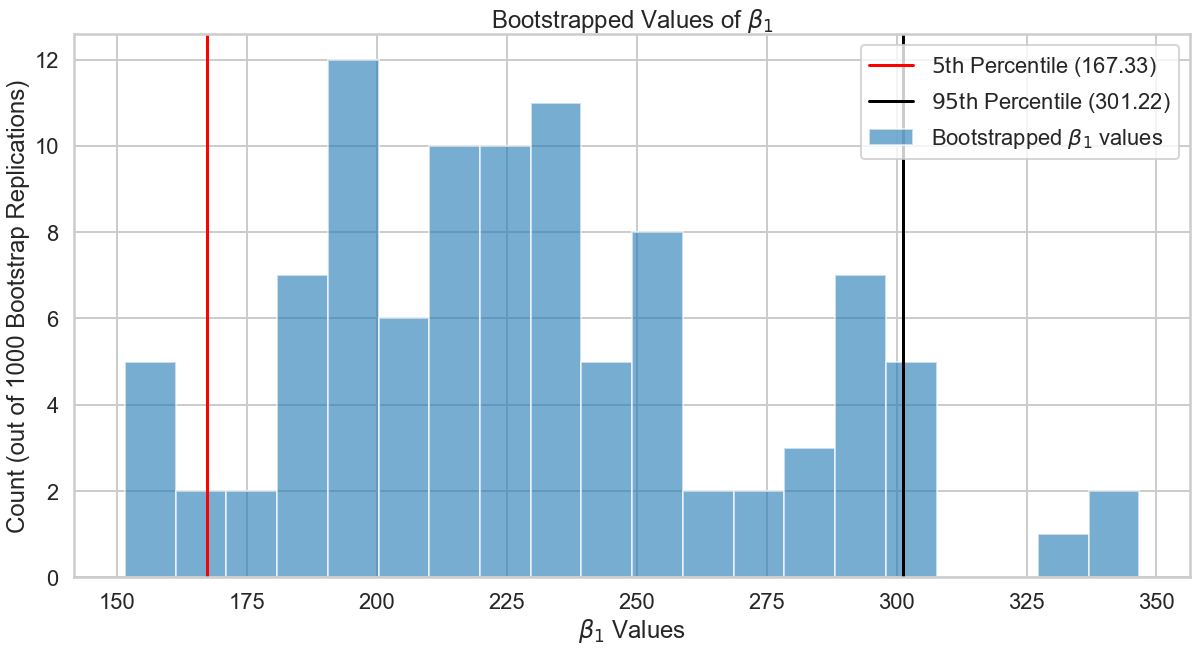

In [10]:
N = 100
bootstrap_beta1s = np.zeros(N)
for cur_bootstrap_rep in range(N):
    # select indices that are in the resample (easiest way to be sure we grab y values that match the x values)
    inds_to_sample = np.random.choice(xtrain.shape[0], size=xtrain.shape[0], replace=True)
    
    # take the sample
    x_train_resample = xtrain[inds_to_sample]
    y_train_resample = ytrain[inds_to_sample]
    
    # fit the model
    bootstrap_model = LinearRegression().fit(x_train_resample.reshape(-1,1), y_train_resample)
    
    # extract the beta1 and append
    bootstrap_beta1s[cur_bootstrap_rep] = bootstrap_model.coef_[0]

## display the results

# calculate 5th and 95th percentiles
lower_limit, upper_limit = np.percentile(bootstrap_beta1s,[5,95])

# plot histogram and bounds
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.hist(bootstrap_beta1s, 20, alpha=0.6, label=r"Bootstrapped $\beta_{1}$ values")
ax.axvline(lower_limit, color='red', label=r"$5$th Percentile ({:.2f})".format(lower_limit))
ax.axvline(upper_limit, color='black', label=r"$95$th Percentile ({:.2f})".format(upper_limit))

# good plots have labels
ax.set_xlabel(r"$\beta_{1}$ Values")
ax.set_ylabel("Count (out of 1000 Bootstrap Replications)")
plt.title(r"Bootstrapped Values of $\beta_{1}$")
plt.legend();

In [11]:
simp_reg = LinearRegression() # build the the ordinary least squares model

simp_reg.fit(xtrain.reshape(-1,1), ytrain) # fit the model to training data

# save the beta coefficients
beta0_sreg = simp_reg.intercept_
beta1_sreg = simp_reg.coef_[0]
regression_coeffs = dict()
regression_coeffs['OLS'] = [np.nan]*2 # Initialize to NaN
regression_coeffs[r'Ridge $\lambda = 0$'] = [np.nan]*2
dfResults = pd.DataFrame(regression_coeffs) 
dfResults.rename({0: r'$\beta_{0}$', 1: r'$\beta_{1}$'}, inplace=True) 
dfResults['OLS'][:] = [beta0_sreg, beta1_sreg]
ypredict_ols = simp_reg.predict(x.reshape(-1,1))
dfResults

,OLS,Ridge $\lambda = 0$
$\beta_{0}$,39659.643416,NaN
$\beta_{1}$,227.957011,NaN


In [12]:
from sklearn.linear_model import Ridge 
ridge_reg = Ridge(alpha = 0) # build the ridge regression model with specified lambda, i.e. alpha

ridge_reg.fit(xtrain.reshape(-1,1), ytrain) # fit the model to training data

# save the beta coefficients
beta0_ridge = ridge_reg.intercept_
beta1_ridge = ridge_reg.coef_[0]

ypredict_ridge = ridge_reg.predict(x.reshape(-1,1)) # make predictions everywhere

dfResults[r'Ridge $\lambda = 0$'][:] = [beta0_ridge, beta1_ridge]
dfResults

,OLS,Ridge $\lambda = 0$
$\beta_{0}$,39659.643416,39659.643416
$\beta_{1}$,227.957011,227.957011


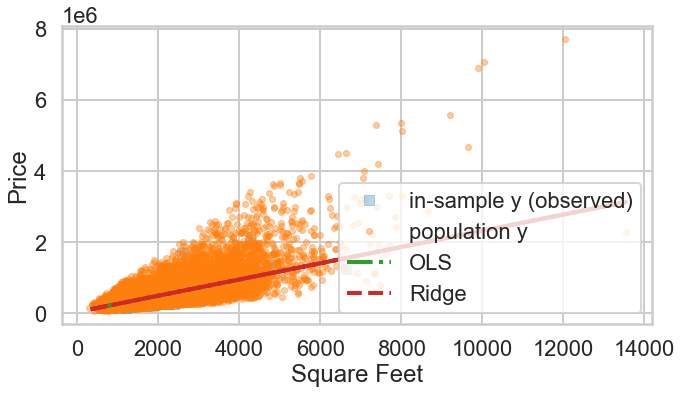

In [13]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(xtrain, ytrain, 's', alpha=0.3, ms=10, label="in-sample y (observed)") # plot in-sample training data
ax.plot(x, y, '.', alpha=0.4, label="population y") # plot population data
ax.plot(x, ypredict_ols, ls='-.', lw=4, label="OLS") # plot simple linear regression fit
ax.plot(x, ypredict_ridge, ls='--', lw = 4, label="Ridge") # plot ridge regression fit

ax.set_xlabel('Square Feet')
ax.set_ylabel('Price')

ax.legend(loc=4);

fig.tight_layout()

4.989388735838587 0.0 227.9570106494465 39659.64341629273
4.98938891465491 0.15729398391057034 227.95700734018766 39659.65046124975
4.989389629920512 0.7864710371523096 227.95699410315297 39659.67864107649
4.989390524003144 1.5729448683051184 227.95697755686186 39659.71386585513
5.181810034575912 217196.39427948138 224.69510488333907 46603.792280292546


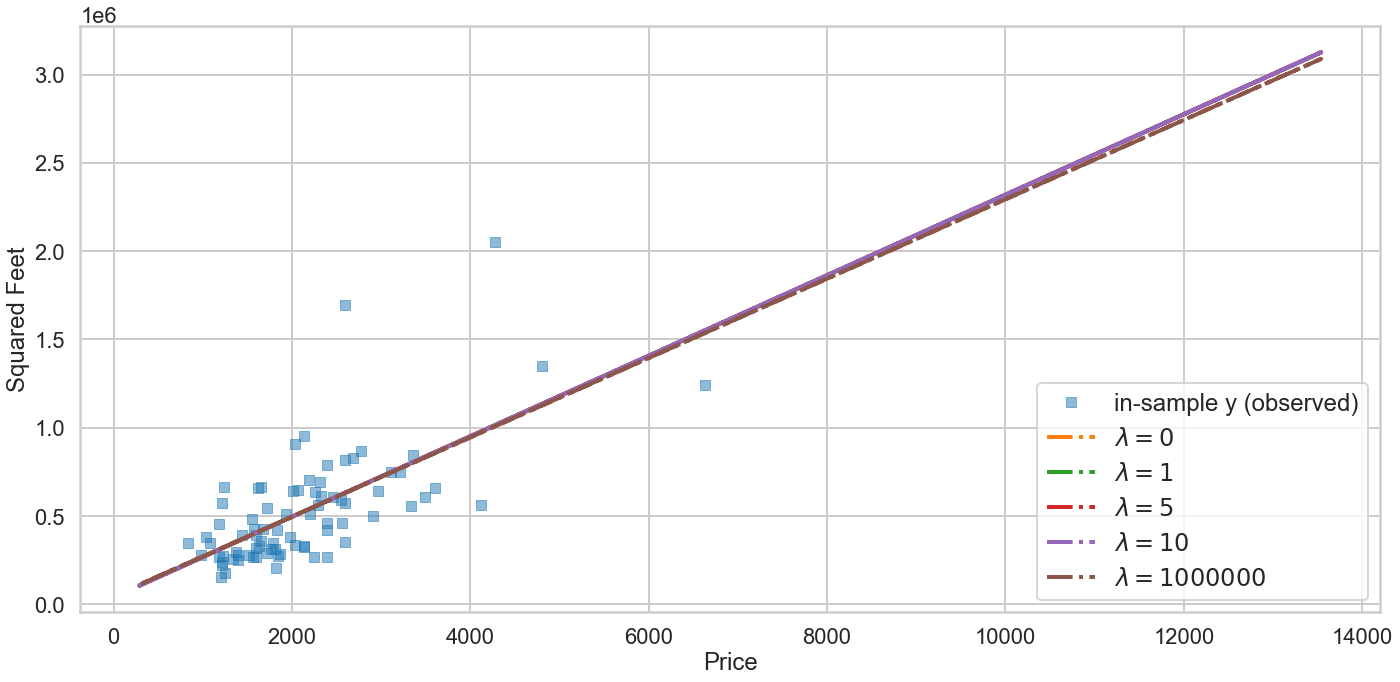

In [14]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

pen_params = [0, 1,5, 10, 1000000]


ax.plot(xtrain, ytrain, 's', alpha=0.5, ms=10, label="in-sample y (observed)") # plot in-sample training data

for alpha in pen_params:
    ridge_reg = Ridge(alpha = alpha) # build the ridge regression model with specified lambda, i.e. alpha
    ridge_reg.fit(xtrain.reshape(-1,1), ytrain) # fit the model to training data
    ypredict_ridge = ridge_reg.predict(x.reshape(-1,1))
    print(sum((ytrain-ridge_reg.coef_[0]*xtrain+ ridge_reg.intercept_)**2)/1000000000000,alpha*(ridge_reg.coef_[0]**2+ ridge_reg.intercept_**2)/10000000000,ridge_reg.coef_[0] ,ridge_reg.intercept_)
    ax.plot(x, ypredict_ridge, ls='-.', lw = 4, label=r"$\lambda = {}$".format(alpha)) # plot ridge regression fit

ax.set_xlabel('Price')
ax.set_ylabel('Squared Feet')

ax.legend(loc=4, fontsize=24);

fig.tight_layout()

fig.savefig('ridge_lambda.png')

The penalty function in ridge regression, 
$ \space 
  L_{\text{ridge}}(\boldsymbol{\beta}) = \frac{1}{n} \sum_{i=1}^n \|y_i - \boldsymbol{\beta}^T \mathbf{x}_i\|^2 + \lambda \sum_{j=1}^m \beta_{j}^{2}
$

Seems to be affected very little by changes in the value of lamda. This is due to the linear trend and wide range of the data. 

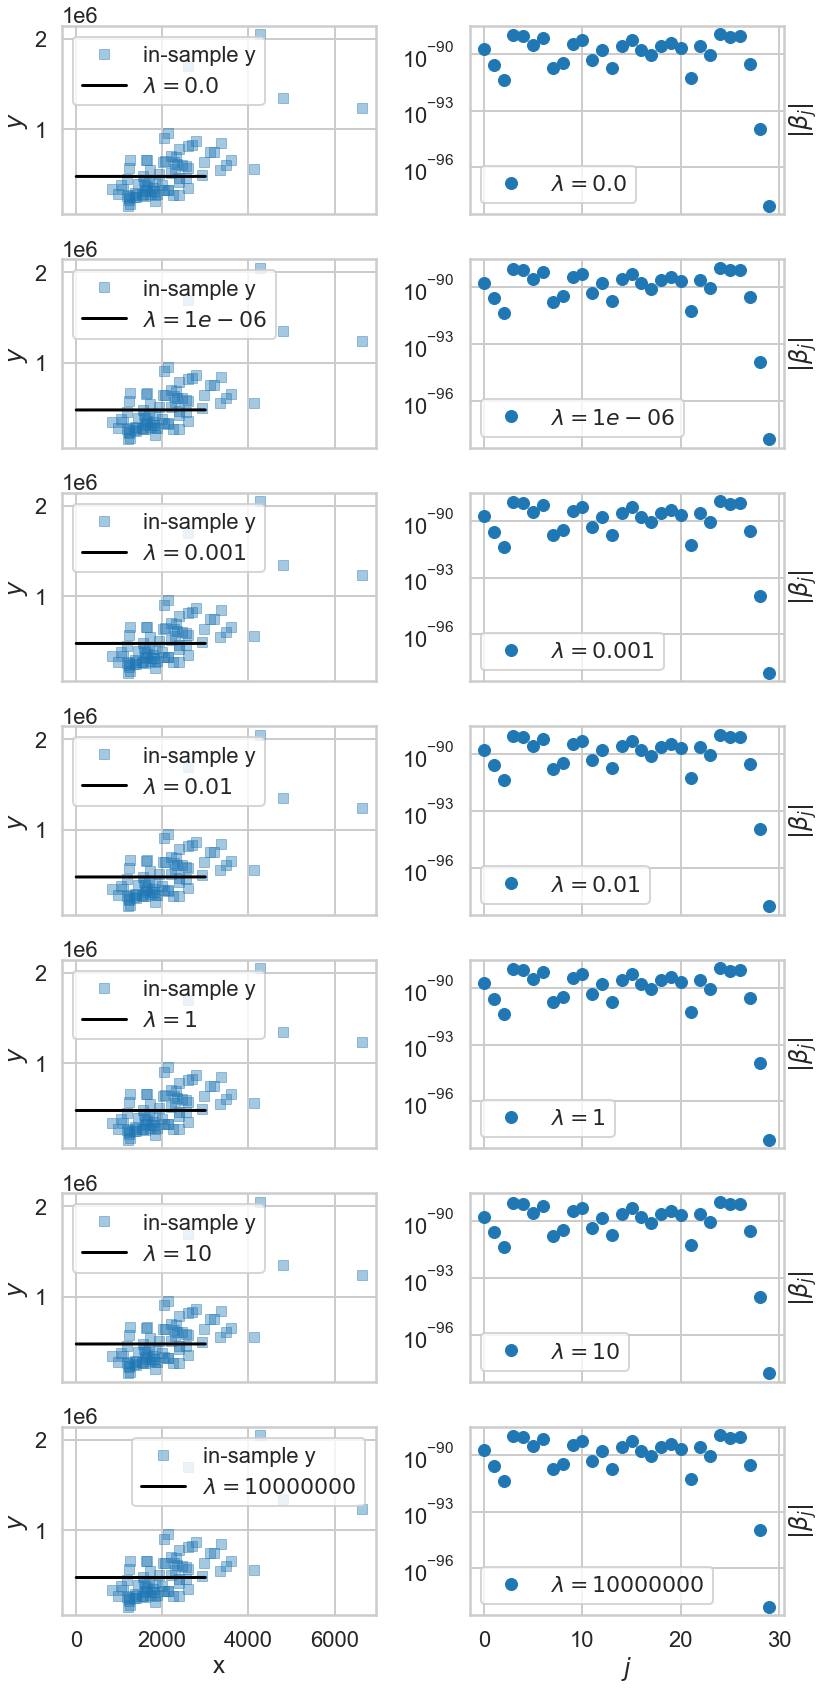

In [15]:
from sklearn.preprocessing import PolynomialFeatures
d = 29 # Maximum polynomial degree
# You will create a grid of plots of this size (7 x 2)
rows = 7
cols = 2
lambdas = [0., 1e-6, 1e-3, 1e-2, 1, 10,10000000] # Various penalization parameters to try
grid_to_predict = np.arange(0, 3000, 1) # Predictions will be made on this grid

# Create training set and test set
Xtrain = PolynomialFeatures(d).fit_transform(xtrain.reshape(-1,1))
test_set = PolynomialFeatures(d).fit_transform(grid_to_predict.reshape(-1,1))
#print(xtrain.reshape(-1,1),grid_to_predict.reshape(-1,1))
fig, axs = plt.subplots(rows, cols, sharex='col', figsize=(12, 24)) # Set up plotting objects

for i, lam in enumerate(lambdas):
    # your code here
    ridge_reg = Ridge(alpha = lam) # Create regression object
    ridge_reg.fit(Xtrain, ytrain) # Fit on regression object
    ypredict_ridge = ridge_reg.predict(test_set) # Do a prediction on the test set
    
    ### Provided code
    axs[i,0].plot(xtrain, ytrain, 's', alpha=0.4, ms=10, label="in-sample y") # Plot sample observations
    axs[i,0].plot(grid_to_predict, ypredict_ridge, 'k-', label=r"$\lambda =  {0}$".format(lam)) # Ridge regression prediction
    axs[i,0].set_ylabel('$y$') # y axis label
   
    axs[i,0].legend(loc='best') # legend
    
    coef = ridge_reg.coef_.ravel() # Unpack the coefficients from the regression
    
    axs[i,1].semilogy(np.abs(coef), ls=' ', marker='o', label=r"$\lambda =  {0}$".format(lam)) # plot coefficients
    
    axs[i,1].yaxis.set_label_position("right") # Move y-axis label to right
    axs[i,1].set_ylabel(r'$\left|\beta_{j}\right|$') # Label y-axis
    axs[i,1].legend(loc='best') # Legend

# Label x axes
axs[-1, 0].set_xlabel("x")
axs[-1, 1].set_xlabel(r"$j$")
fig.tight_layout()


It seems that there is no polynomial up to degree 30 that can fit the data more precisely.

Once again the values of lamda do not affect results very much in this case.

In [16]:
from sklearn.model_selection import GridSearchCV
def cv_optimize_ridge(x: np.ndarray, y: np.ndarray, list_of_lambdas: list, n_folds: int =4):
    est = Ridge()
    parameters = {'alpha': list_of_lambdas}
    # the scoring parameter below is the default one in ridge, but you can use a different one
    # in the cross-validation phase if you want.
    gs = GridSearchCV(est, param_grid=parameters, cv=n_folds, scoring="neg_mean_squared_error")
    gs.fit(x, y)
    return gs

In [17]:
lambs = [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]
# your code here
fitmodel = cv_optimize_ridge(Xtrain, ytrain, lambs, n_folds=4)

In [18]:
print(fitmodel.best_estimator_, "\n")
print(fitmodel.best_params_, "\n")
print(fitmodel.best_score_, "\n")

Ridge(alpha=1e-08) 

{'alpha': 1e-08} 

-1.0471987871247086e+25 



In [19]:
fitmodel.cv_results_

{'mean_fit_time': array([0.00206143, 0.00142503, 0.00124878, 0.00171417, 0.0009945 ,
        0.00124586, 0.0012393 , 0.0007475 , 0.00099868, 0.00074661,
        0.00049853]),
 'std_fit_time': array([1.12900370e-04, 3.76630540e-04, 4.36113183e-04, 5.87898384e-04,
        2.18107396e-06, 4.31640706e-04, 4.34033771e-04, 4.31570405e-04,
        7.07564152e-04, 4.31054906e-04, 4.98533277e-04]),
 'mean_score_time': array([0.00112969, 0.00042903, 0.00025189, 0.0003767 , 0.00024909,
        0.00099921, 0.00074911, 0.00024974, 0.00050265, 0.00024885,
        0.00049824]),
 'std_score_time': array([0.00090017, 0.00048669, 0.00043628, 0.00040993, 0.00043143,
        0.00070715, 0.00043251, 0.00043257, 0.00050268, 0.00043102,
        0.00049824]),
 'param_alpha': masked_array(data=[1e-08, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001,
                    0.01, 0.1, 1.0, 10.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False],
       

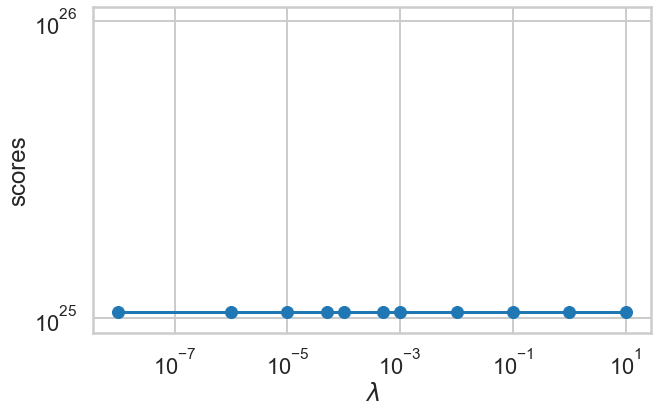

In [20]:
fit_lambdas = [d['alpha'] for d in fitmodel.cv_results_['params']]
fit_scores = fitmodel.cv_results_['mean_test_score']
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(fit_lambdas, -fit_scores, ls='-', marker='o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\lambda$')
ax.set_ylabel('scores');

In [21]:
from sklearn.model_selection import cross_val_score

lr_object =  Ridge(alpha=0)
cross_val_score(lr_object, Xtrain, ytrain, cv=3)

array([ 1.01649924e-02, -7.76200710e+14, -6.57218702e+04])

In [22]:
for cur_alpha in [1e-8, 1e-4, 1e-2, 1.0, 10.0]:
    lr_object =  Ridge(alpha=cur_alpha)
    scores = cross_val_score(lr_object, Xtrain, ytrain, cv=5)
    print("lambda {0}\t R^2 scores: {1}\t Mean R^2: {2}".format(cur_alpha,scores,np.mean(scores)))

lambda 1e-08	 R^2 scores: [-4.08241290e-01 -8.35006452e-02 -6.40211735e-01 -3.28667206e+14
 -6.08571283e+04]	 Mean R^2: -65733441167360.02
lambda 0.0001	 R^2 scores: [-4.08241290e-01 -8.35006452e-02 -6.40211735e-01 -3.28667206e+14
 -6.08571283e+04]	 Mean R^2: -65733441167360.02
lambda 0.01	 R^2 scores: [-4.08241290e-01 -8.35006452e-02 -6.40211735e-01 -3.28667206e+14
 -6.08571283e+04]	 Mean R^2: -65733441167360.02
lambda 1.0	 R^2 scores: [-4.08241290e-01 -8.35006452e-02 -6.40211735e-01 -3.28667206e+14
 -6.08571283e+04]	 Mean R^2: -65733441167360.02
lambda 10.0	 R^2 scores: [-4.08241290e-01 -8.35006452e-02 -6.40211735e-01 -3.28667206e+14
 -6.08571283e+04]	 Mean R^2: -65733441167360.02


Best model searched:
alpha = 1e-08
intercept = 479273.3935588159
betas = [ 1.72218113e-90 -2.73080730e-91 -4.17351962e-92  9.46398470e-90
 -8.78061074e-90 -2.94044296e-90 -6.73675107e-90 -1.69651244e-91
 -3.39132277e-91  3.44282479e-90  5.39864733e-90  4.75463249e-91
 -1.60870294e-90  1.87013461e-91  2.62320169e-90 -5.32226330e-90
  1.67764324e-90 -8.37609025e-91 -2.48461152e-90  3.58117642e-90
 -2.08759425e-90 -5.40833949e-92  2.57227853e-90 -8.94768813e-91
  1.09724475e-89  8.03324804e-90 -8.42779745e-90  2.97641638e-91
 -1.05811267e-94  9.21716703e-99], 
Best model searched:
alpha = 1e-08
intercept = 479273.3935588159
betas = [ 1.72218113e-90 -2.73080730e-91 -4.17351962e-92  9.46398470e-90
 -8.78061074e-90 -2.94044296e-90 -6.73675107e-90 -1.69651244e-91
 -3.39132277e-91  3.44282479e-90  5.39864733e-90  4.75463249e-91
 -1.60870294e-90  1.87013461e-91  2.62320169e-90 -5.32226330e-90
  1.67764324e-90 -8.37609025e-91 -2.48461152e-90  3.58117642e-90
 -2.08759425e-90 -5.40833949e-92  2.57

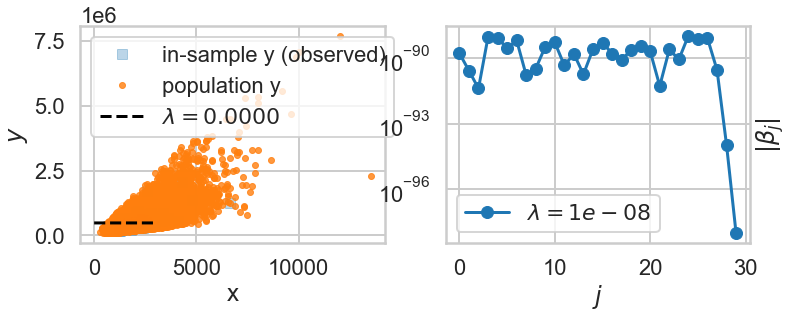

In [27]:
from sklearn.linear_model import RidgeCV

ridgeCV_object = RidgeCV(alphas=(1e-8, 1e-4, 1e-2, 1.0, 10.0), cv=5)
ridgeCV_object.fit(Xtrain, ytrain)
print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(ridgeCV_object.alpha_,
                                                                            ridgeCV_object.intercept_,
                                                                            ridgeCV_object.coef_
                                                                            )
     )

from sklearn.model_selection import KFold
splitter = KFold(5, random_state=42, shuffle=True)

ridgeCV_object = RidgeCV(alphas=(1e-8, 1e-4, 1e-2, 1.0, 10.0), cv=splitter)
ridgeCV_object.fit(Xtrain, ytrain)
print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(ridgeCV_object.alpha_,
                                                                            ridgeCV_object.intercept_,
                                                                            ridgeCV_object.coef_
                                                                            )
     )
# your code here
best_lambda = fitmodel.best_params_['alpha']
est = Ridge(alpha=best_lambda).fit(Xtrain,ytrain)
ypredict_ridge_best = est.predict(test_set)
est.coef_
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
left = 0
right = 1
axs[left].plot(xtrain, ytrain, 's', alpha=0.3, ms=10, label="in-sample y (observed)")
axs[left].plot(x, y, '.', alpha=0.8, label="population y")
axs[left].plot(grid_to_predict, ypredict_ridge_best, 'k--', label=r"$\lambda =  {{{0:1.4f}}}$".format(best_lambda))
axs[left].set_ylabel('$y$')
axs[left].legend(loc=2)
coef = est.coef_.ravel()
axs[right].semilogy(np.abs(coef), marker='o', label=r"$\lambda =  {0}$".format(best_lambda))
axs[right].yaxis.set_label_position("right")
axs[right].set_ylabel(r'$\left|\beta_{j}\right|$')
axs[right].legend(loc='best')
axs[left].set_xlabel("x")
axs[right].set_xlabel(r'$j$');

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2107908593174.1023, tolerance: 806561210.674195
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2107908593174.1309, tolerance: 806561210.674195
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2107908593174.3262, tolerance: 806561210.674195
  model = cd_fast.enet_coordinate_descent(
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

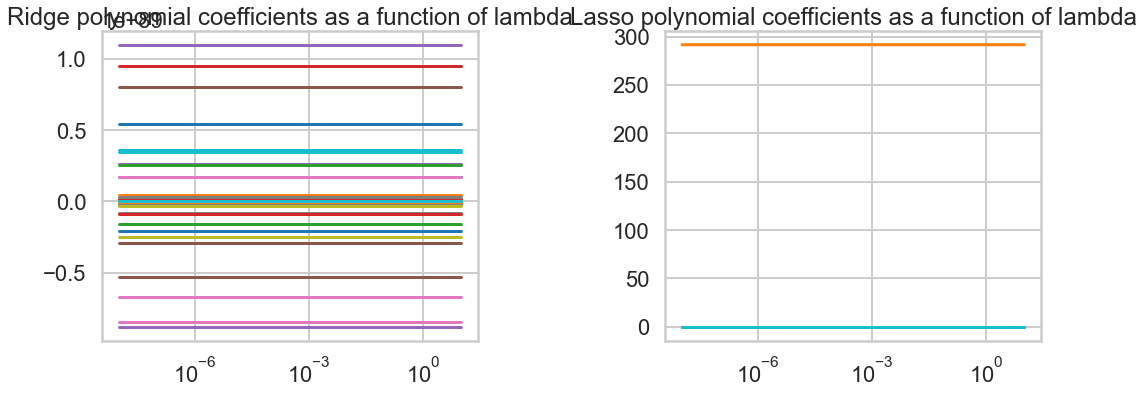

In [29]:
#One more nice plot:
from sklearn.linear_model import Lasso 

ridge_coef = []
lasso_coef = []
for lamb in lambs:
    ridge_coef.append(Ridge(alpha=lamb).fit(Xtrain,ytrain).coef_)
    lasso_coef.append(Lasso(alpha=lamb).fit(Xtrain,ytrain).coef_)
ridge_coef[0:2]
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
left = 0
right = 1
axs[left].plot(lambs,ridge_coef)
axs[left].set_xscale("log")
axs[left].set_title("Ridge polynomial coefficients as a function of lambda")
#axs[left].legend(loc='best')
axs[right].plot(lambs,lasso_coef)
axs[right].set_xscale("log")
axs[right].set_title("Lasso polynomial coefficients as a function of lambda")

fig.tight_layout()